# Title

[Free Form Description]

**Resources**

- [Spotify Web API reference](https://developer.spotify.com/documentation/web-api/reference/)
- [Spotipy docs (Python Wrapper)](https://spotipy.readthedocs.io/en/latest/)


**Data Output:**

- `data/processed/audio_data.csv`: DataFrame of all CC tracks with "Sonic Brutality Index"

**Changes**

- 2019-02-18: Start project
- 20-02-25: Complete audio analysis



---

## Import libraries, instantiate client

In [1]:
# Import libraries

from pprint import pprint
import json
import numpy as np
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import credentials  # file where secret discogs credentials are stored


# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('raph-base')
import seaborn as sns 

In [2]:
# Import credentials and instantiate client with authorization

SPOTIPY_CLIENT_ID = credentials.client_id
SPOTIPY_CLIENT_SECRET = credentials.client_secret

client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, 
                                                      client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Request data

### Artist

In [3]:
# Get Artist URI

name = "Cannibal Corpse"

def get_artist_uri(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    artist_uri = items[0]['uri'] 
    return artist_uri

In [4]:
artist_uri = get_artist_uri(name)
pprint(artist_uri)

'spotify:artist:0yLwGBQiBqhXOvmTfH2A7n'


### Trackslist

The easiest way to query for tracks is as follows:

```python
results = sp.search(q=artist, limit=50, type='track')
for i, t in enumerate(results['tracks']['items']):
    print(' ', i, t['name'])
```

But problem is that the upper limit possible is 50, and CC have released many more songs than that, so I will try a work around. Get a list of all albums, clean it a bit and then combine all the tracks of each single album in the list.

In [5]:
# Get Artist albums (dict)
# Note: setting title as key catches some duplicates

def get_artist_albums(artist_uri):
    albums = {}
    results = sp.artist_albums(artist_uri, album_type='album')
    for i, item in enumerate(results['items']):
        albums[item['name'].title()] = item['uri']
    return albums

In [6]:
artist_albums = get_artist_albums(artist_uri)
pprint(artist_albums)

{'A Skeletal Domain': 'spotify:album:3Am2ExqPJjrw51AU2HRJSF',
 'Bloodthirst': 'spotify:album:4AObEzsEDC6WOAlJCRL9Pa',
 'Evisceration Plague': 'spotify:album:03jcqKD4ZthRxviJQIPCYf',
 'Gallery Of Suicide': 'spotify:album:3fEMj3Nr6Dpu7rFvgi1rg9',
 'Global Evisceration': 'spotify:album:4OZFh833qdZrK6DyelNAwS',
 'Gore Obsessed': 'spotify:album:4QnPTzLdkNwnvXxjKZ3AgF',
 'Kill': 'spotify:album:6ilBwRWtEedIQu4Q0YyIux',
 'Live Cannibalism': 'spotify:album:4eqhYFJAudlSc42bj0JKa9',
 'Red Before Black': 'spotify:album:2Ecgc9nNxJpXd3gboFPbvz',
 'The Bleeding': 'spotify:album:1FOBUa0z9RhKPH0frnWMRa',
 'The Bleeding - Reissue': 'spotify:album:18byNZK0g3PGvvebCYQpwm',
 'The Wretched Spawn': 'spotify:album:46QEzkj6cg7FxmIHL7zTjR',
 'Tomb Of The Mutilated': 'spotify:album:2yPAe2RJCfrfV97c8FKKjb',
 'Torture': 'spotify:album:7AaZ6zhZXDKilXqsJ52g8b',
 'Torturing And Eviscerating': 'spotify:album:2RInJ5yUQ4HWqQbvMi9QYw',
 'Vile': 'spotify:album:6jgJTpnqytev0AHfkpFKFb',
 'Vile (Expanded Edition)': 'spotify:

In [7]:
# Manually clean some entries, we want originals only and no live albums
albums_to_delete = ['レッド・ビフォー・ブラック', 
                     'Vile (Expanded Edition)', 
                     'The Bleeding - Reissue',
                     'Live Cannibalism',
                     'Torturing And Eviscerating',
                   ]
def get_clean_album_uri_list(artist_albums, albums_to_delete=albums_to_delete):
    if albums_to_delete is not None:
        for key in albums_to_delete:
            artist_albums.pop(key)  
    artist_albums_uri = [uri for uri in artist_albums.values()]
    return artist_albums_uri

In [8]:
artist_albums_uri = get_clean_album_uri_list(artist_albums, albums_to_delete)
print(artist_albums_uri)

['spotify:album:2Ecgc9nNxJpXd3gboFPbvz', 'spotify:album:3Am2ExqPJjrw51AU2HRJSF', 'spotify:album:7AaZ6zhZXDKilXqsJ52g8b', 'spotify:album:4OZFh833qdZrK6DyelNAwS', 'spotify:album:03jcqKD4ZthRxviJQIPCYf', 'spotify:album:6ilBwRWtEedIQu4Q0YyIux', 'spotify:album:46QEzkj6cg7FxmIHL7zTjR', 'spotify:album:4QnPTzLdkNwnvXxjKZ3AgF', 'spotify:album:4AObEzsEDC6WOAlJCRL9Pa', 'spotify:album:3fEMj3Nr6Dpu7rFvgi1rg9', 'spotify:album:6jgJTpnqytev0AHfkpFKFb', 'spotify:album:1FOBUa0z9RhKPH0frnWMRa', 'spotify:album:2yPAe2RJCfrfV97c8FKKjb']


In [9]:
def get_full_tracklist_dict(artist_albums_uri):
    tracklist = {}
    for album_uri in artist_albums_uri:
        album = sp.album(album_uri)
        for track in album['tracks']['items']:
            tracklist[track['name'].title()] = track['uri']
    return tracklist

In [10]:
full_tracklist = get_full_tracklist_dict(artist_albums_uri)
print(list(full_tracklist.items())[0])
print("Total tracks:", len(full_tracklist))

('Only One Will Die', 'spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q')
Total tracks: 144


### Audio Features

We use the audio features provided by spotify ([see here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)) to determine the sonic brutality of a track. We actually only need `Energy`and `Valence` for that, but in addition let's also have a look at the `Dancability`of Cannibal Corpse. Just for fun.

> Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    
> Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 
    
> Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

In [11]:
def get_audio_features_dict(full_tracklist):
    audio_features_dict = {}
    for uri in list(full_tracklist.values()):
        features = sp.audio_features(uri)
        audio_features_dict[uri] = {'energy': features[0]['energy'],
                                    'valence': features[0]['valence'],
                                    'danceability': features[0]['danceability'],
                                   }
    return audio_features_dict

In [12]:
audio_features_dict = get_audio_features_dict(full_tracklist)
pprint(list(audio_features_dict.items())[:2])

retrying ...3secs
[('spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q',
  {'danceability': 0.24, 'energy': 0.981, 'valence': 0.217}),
 ('spotify:track:1M3QUZOIhq8LNkMJ8axsLM',
  {'danceability': 0.368, 'energy': 0.994, 'valence': 0.129})]


## Analyse Songs

### Prepare dataframe

Getting the songs and features in separate dicts was ok for exploring the Spotify API and Spotipy wrapper, but for our the actual Analyis I prefer to combine everything in a dataframe.

In [13]:
temp_df1 = pd.DataFrame(full_tracklist.items(), columns = ['title', 'uri'])
temp_df2 = pd.DataFrame(audio_features_dict.items(), columns = ['uri', 'features'])
assert len(temp_df1) == len(temp_df2)
song_data = pd.merge(temp_df1, temp_df2, on=['uri'])
display(song_data.head(2))

,title,uri,features
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,"{'energy': 0.981, 'valence': 0.217, 'danceabil..."
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,"{'energy': 0.994, 'valence': 0.129, 'danceabil..."


In [14]:
song_data['energy'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['energy'])
song_data['valence'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['valence'])
song_data['danceability'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['danceability'])
song_data.drop('features', axis=1, inplace=True)

In [15]:
display(song_data.head(2))

,title,uri,energy,valence,danceability
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368


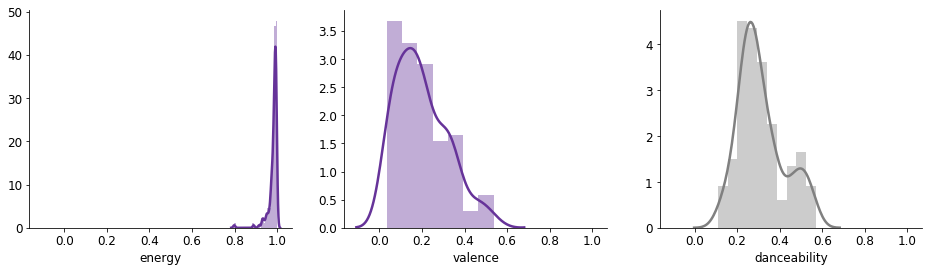

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(16,4))

sns.distplot(song_data['energy'], ax=axes[0])
sns.distplot(song_data['valence'], ax=axes[1])
sns.distplot(song_data['danceability'],color="grey", ax=axes[2]);

In [17]:
# Check for outlier with energy value of approx. 0.8 only
# And get link to a 30 sek sample

low_energy_uri = song_data['uri'].loc[song_data['energy'] == song_data['energy'].min()].values[0]
results = sp.track(low_energy_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])


track       : From Skin to Liquid
from ablbum : Gallery of Suicide
audio       : https://p.scdn.co/mp3-preview/b365c4e05003bd21bc5387aa0cc123a319a9a061?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b27330ad46095a88e6fad36ecded


### Calculate "Sonic Brutality Index"

Using both `energy` and `valence`, we can create an equation for the “Sonic Brutality Index” by calculating the geometric mean of `energy` and `1 - valence` (subtracting valence from 1 so that a higher value means it’s more “negative”). This way, the most brutal songs will be those that are both high in energy and low in valence, while equally weighting both.

$$\\Sonic Brutality Index = \sqrt{(1 - valence) * energy}$$

In [18]:
def calc_sbi(valence, energy):
    sbi = np.sqrt((1 - valence) * energy)
    return sbi
    
song_data['sbi'] = song_data.apply(lambda x: calc_sbi(x['valence'], x['energy']), axis=1)
display(song_data.head(2))

,title,uri,energy,valence,danceability,sbi
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240,0.876426
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368,0.930470


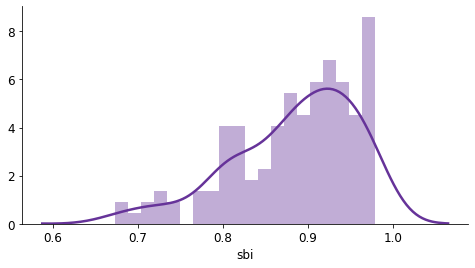

In [19]:
plt.figure(figsize=(8,4))
sns.distplot(song_data['sbi'], bins=20);

In [20]:
# Check for most brutal song (accustically)

most_brutal_uri = song_data['uri'].loc[song_data['sbi'] == song_data['sbi'].max()].values[0]
results = sp.track(most_brutal_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : High Velocity Impact Spatter
from ablbum : A Skeletal Domain
audio       : https://p.scdn.co/mp3-preview/5c8d9c416d2f43696ce70afa3dde9cb8fecf1868?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b273898682ca3585a746e501fce3


Youtube-Clip: 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=57WwWg9PD74
" target="_blank"><img src="http://img.youtube.com/vi/57WwWg9PD74/0.jpg" 
alt="Link to Youtube clip" width="240" height="180" border="10" /></a>

In [21]:
song_data.sort_values(['sbi'], ascending=False)

,title,uri,energy,valence,danceability,sbi
12,High Velocity Impact Spatter,spotify:track:4rRvOO1KBtBYLmOU1PTjgr,0.997,0.0371,0.301,0.979802
106,Sentenced To Burn,spotify:track:5CPHlT9vuwc7rSa76zzKya,0.993,0.0348,0.360,0.979001
4,Remaimed,spotify:track:4KlpnaOREJpWNjuoZPeOQ7,0.998,0.0397,0.395,0.978969
91,Sanded Faceless,spotify:track:6Pc9WrmJwQ8PnirdzZs21w,0.997,0.0390,0.245,0.978835
117,Crushing The Despised,spotify:track:4g2XQt5ux2eO95D188I7nB,0.998,0.0422,0.478,0.977693
...,...,...,...,...,...,...
118,Mummified In Barbed Wire,spotify:track:27kkzK4l8CqqNdu7vKnaMP,0.961,0.4780,0.375,0.708267
122,Relentless Beating,spotify:track:0ox3y11lj7cGdgS1uAsW02,0.988,0.4930,0.176,0.707754
48,Disfigured,spotify:track:67gauLFb25vQYR7qMhNnTT,0.915,0.4820,0.245,0.688455
34,Rabid,spotify:track:2V2ypDfO6zxqqgOEEWBXEB,0.994,0.5370,0.514,0.678397


In [22]:
# Lets listen to a not so brutal but danceable track now
# (don't expect too much though ...)

rabid_uri = song_data['uri'].loc[song_data['title'] == 'Rabid'].values[0]
results = sp.track(rabid_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : Rabid
from ablbum : Torture
audio       : https://p.scdn.co/mp3-preview/bb6155d3c987905c085cf31ed95d532f4ba16795?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b2732d3c8436b5316b6074f407f9


Before we save the data and go on, we will first append the duration of each song to the dataframe. This is something we'll need for the calculation of the "Lyrical Brutality Index" in the next notebook.

In [23]:
def get_duration(list_of_song_uri):
    duration_dict = {}
    for song_uri in list_of_song_uri:
        results = sp.track(song_uri)
        duration_dict[song_uri] = results['duration_ms']
        
    return duration_dict

In [29]:
duration_dict = get_duration(full_tracklist.values())
song_data['duration_sec'] = song_data['uri'].apply(lambda x: duration_dict[x] / 1000)  # values are in ms
display(song_data.head(2))

,title,uri,energy,valence,danceability,sbi,duration_sec
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240,0.876426,204.320
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368,0.930470,192.226


In [30]:
## Save data
song_data.to_csv('data/processed/audio_data.csv', index=False)

---

## Appendix: Compare Sonic Brutality of Cannibal Corpse and Cannabis Corpse

In [24]:
# Retrieve data from API

name2 = "Cannabis Corpse"

artist_uri2 = get_artist_uri(name2)
artist_albums2 = get_artist_albums(artist_uri2)
artist_albums_uri2 = get_clean_album_uri_list(artist_albums2, albums_to_delete=None)
full_tracklist2 = get_full_tracklist_dict(artist_albums_uri2)
audio_features_dict2 = get_audio_features_dict(full_tracklist2)
pprint(list(audio_features_dict2.items())[:2])
print("\nTotal Number of songs:", len(audio_features_dict2))

retrying ...5secs
[('spotify:track:3YFR8VPZDxR1euZwXOaYke',
  {'danceability': 0.227, 'energy': 0.951, 'valence': 0.184}),
 ('spotify:track:3FawebmSoA8lo0Qq4sRtlU',
  {'danceability': 0.29, 'energy': 0.926, 'valence': 0.213})]

Total Number of songs: 60


In [25]:
# Construct DataFrame

temp_df1 = pd.DataFrame(full_tracklist2.items(), columns = ['title', 'uri'])
temp_df2 = pd.DataFrame(audio_features_dict2.items(), columns = ['uri', 'features'])
assert len(temp_df1) == len(temp_df2)
song_data2 = pd.merge(temp_df1, temp_df2, on=['uri'])

song_data2['energy'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['energy'])
song_data2['valence'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['valence'])
song_data2['danceability'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['danceability'])
song_data2.drop('features', axis=1, inplace=True)

In [26]:
# Calculae SBI

song_data2['sbi'] = song_data2.apply(lambda x: calc_sbi(x['valence'], x['energy']), axis=1)
display(song_data2.head(2))

,title,uri,energy,valence,danceability,sbi
0,Conquerors Of Chronageddon,spotify:track:3YFR8VPZDxR1euZwXOaYke,0.951,0.184,0.227,0.880918
1,Nug So Vile,spotify:track:3FawebmSoA8lo0Qq4sRtlU,0.926,0.213,0.290,0.853676


In [27]:
# Compare Brutality of Cannibal Corpse and Cannabis Corpse

print(f"Mean Brutality Score for {name}: {song_data['sbi'].mean():.2f}")
print(f"Mean Brutality Score for {name2}: {song_data2['sbi'].mean():.2f}")

Mean Brutality Score for Cannibal Corpse: 0.88
Mean Brutality Score for Cannabis Corpse: 0.84


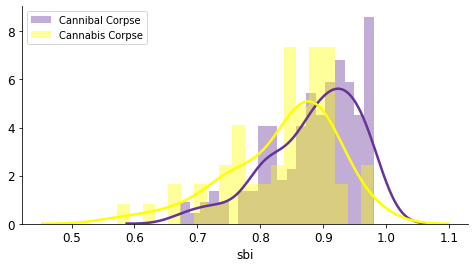

In [28]:
plt.figure(figsize=(8,4))
sns.distplot(song_data['sbi'], bins=20, label=name);
sns.distplot(song_data2['sbi'], color='yellow', bins=20, label=name2);
plt.legend(loc='upper left');

In [35]:
most_brutal_uri2 = song_data2['uri'].loc[song_data2['sbi'] == song_data2['sbi'].max()].values[0]
results = sp.track(most_brutal_uri2)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : I Cum Bud
from ablbum : Blunted at Birth
audio       : https://p.scdn.co/mp3-preview/12fb2294c21479731e01a25bf814e1ff5bc9d246?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b273e401d75c45b023c7194242f3


In [30]:
song_data2.nlargest(1, 'sbi')

,title,uri,energy,valence,danceability,sbi
36,I Cum Bud,spotify:track:4FmDKCCpfbQoAy8svpRAYO,0.996,0.0367,0.307,0.979514


---